In [29]:
import torch
#%matplotlib nbagg
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep

hep.style.use("CMS")


df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
signalname="GluGluToRadionToHHTo2G2Tau_M-1000"
sig = df[df.process_id == proc_dict[f"{signalname}"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\970617314.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [30]:
proc_dict

{'Data': 0,
 'DiPhoton': 3,
 'GluGluToRadionToHHTo2G2Tau_M-1000': -195,
 'GluGluToRadionToHHTo2G2Tau_M-250': -196,
 'GluGluToRadionToHHTo2G2Tau_M-260': -197,
 'GluGluToRadionToHHTo2G2Tau_M-270': -198,
 'GluGluToRadionToHHTo2G2Tau_M-280': -199,
 'GluGluToRadionToHHTo2G2Tau_M-290': -200,
 'GluGluToRadionToHHTo2G2Tau_M-300': -201,
 'GluGluToRadionToHHTo2G2Tau_M-320': -202,
 'GluGluToRadionToHHTo2G2Tau_M-350': -203,
 'GluGluToRadionToHHTo2G2Tau_M-400': -204,
 'GluGluToRadionToHHTo2G2Tau_M-450': -205,
 'GluGluToRadionToHHTo2G2Tau_M-500': -206,
 'GluGluToRadionToHHTo2G2Tau_M-550': -207,
 'GluGluToRadionToHHTo2G2Tau_M-600': -208,
 'GluGluToRadionToHHTo2G2Tau_M-650': -209,
 'GluGluToRadionToHHTo2G2Tau_M-700': -210,
 'GluGluToRadionToHHTo2G2Tau_M-750': -211,
 'GluGluToRadionToHHTo2G2Tau_M-800': -212,
 'GluGluToRadionToHHTo2G2Tau_M-900': -213,
 'TTGG': 7,
 'TTGamma': 6,
 'TTJets': 5,
 'VBFH_M125': 12,
 'VH_M125': 9,
 'WGamma': 4,
 'ZGamma': 2,
 'ggH_M125': 11,
 'ttH_M125': 10,
 'GJets': 8}

In [31]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [32]:
"""The features requiring exclusion of -9 values"""
MinusNineBinning=['ditau_met_dPhi',
                  'ditau_deta',
                  'ditau_dR',
                  'ditau_dphi',
                  'ditau_pt',
                  'Diphoton_ditau_dphi',
                  'dilep_leadpho_mass',
                  'reco_MX_mgg',
                  'Diphoton_ditau_deta',
                  'Diphoton_sublead_lepton_deta',
                  'Diphoton_sublead_lepton_dR',
                  'LeadPhoton_ditau_dR',
                  'ditau_mass']


In [33]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()

TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','ditau_met_dPhi','ditau_deta','Diphoton_sublead_lepton_deta','Diphoton_ditau_deta','ditau_mass','weight_central','Classification']
# includes classification and weights
#TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']

"""A dataset consisting of only the essential features"""
for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    
"""Removal of the values that are binned at -9 from the necessary features"""
for columns in df_TopFeatures.columns:
    if columns in MinusNineBinning:
        df_TopFeatures = df_TopFeatures.loc[(df_TopFeatures[columns] > -8)]


In [34]:
df_TopFeatures = df_TopFeatures.sample(frac=1, random_state=42)  # Setting frac=1 shuffles all rows

features = df_TopFeatures # Extracting features

labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()

weightofsignal=train_features[train_features['Classification']==1]['weight_central'].sum()
weightofbackground=train_features[train_features['Classification']==0]['weight_central'].sum()
scale=weightofsignal/weightofbackground

"""reweighting the weight_central column in entire data 
set such that for background and signal """
train_features.loc[train_features['Classification'] == 0, 'weight_central'] *= scale
test_features.loc[test_features['Classification'] == 0, 'weight_central'] *= scale


train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']



train_features = train_features.drop(columns=['weight_central'])
train_features = train_features.drop(columns=['Classification'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)



In [35]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN,self).__init__()
#         self.hidden1 = nn.Linear(16, 20)
#         self.act1 = nn.ReLU()
#         self.hidden2 = nn.Linear(20, 8)
#         self.act2 = nn.ReLU()
#         self.output = nn.Linear(8, 1)
        self.hidden1 = nn.Linear(16, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 40)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(40, 16)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(16, 8)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.hidden3(x)
        x = self.act3(x)
        x = self.hidden4(x)
        x = self.act4(x)
        x = self.output(x)
        x = self.act_output(x)
        return x


    def weightedBCELoss(self, input, target, weight):
      x, y, w = input, target, weight
      log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
      #return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))
      return -w * (y*log(x) + (1-y)*log(1-x))
    
    def batch_weightedBCELoss(self, input, target, weight, batch_size):
#batch_weightedBCELoss(self, train, train_labels_tensor, train_weights_tensor, batch_size)
        self.batch_size=batch_size

        target=target.unsqueeze(1)
        
        
       # train=model.forward(input)

        total_batch_err=torch.empty(0,1)
        output_length=input.shape[0]
        batch_remainder=output_length%batch_size

        for i in range(0, output_length//batch_size):
            weights = weight[i*(batch_size):(i+1)*(batch_size), :]
            labels = target[i*(batch_size):(i+1)*(batch_size), :]
            inputs = input[i*(batch_size):(i+1)*(batch_size), :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            total_batch_err=torch.cat((total_batch_err,loss)) 
        #    print(total_batch_err.shape[0])

        if batch_remainder > 0:
            weights = weight[(output_length//batch_size)*batch_size:, :]
            labels = target[(output_length//batch_size)*batch_size:, :]
            inputs = input[(output_length//batch_size)*batch_size:, :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            #weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
            total_batch_err=torch.cat((total_batch_err,loss))
        #    print(total_batch_err.shape[0])
            
        return torch.mean(total_batch_err)


In [36]:
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossdata=[]
df_Prediction=pd.DataFrame()
epochs=200
epochlist=[]
for i in range(1,epochs+1):
    epochlist.append(i)
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    trained_data= pd.DataFrame(trained.detach().numpy())
    df_Prediction[f'Epoch {i}'] = trained_data
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
# figure=plt.figure()
# plt.plot(epochlist,lossdata)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()    

For Epoch 1: Loss = 0.0002388564171269536
For Epoch 2: Loss = 0.0002216491848230362
For Epoch 3: Loss = 0.00020809995476156473
For Epoch 4: Loss = 0.00019779543799813837
For Epoch 5: Loss = 0.0001897942420328036
For Epoch 6: Loss = 0.00018288478895556182
For Epoch 7: Loss = 0.00017673739057499915
For Epoch 8: Loss = 0.00017105140432249755
For Epoch 9: Loss = 0.00016554933972656727
For Epoch 10: Loss = 0.00016050980775617063
For Epoch 11: Loss = 0.00015611911658197641
For Epoch 12: Loss = 0.00015224576054606587
For Epoch 13: Loss = 0.00014875906344968826
For Epoch 14: Loss = 0.00014545167505275458
For Epoch 15: Loss = 0.00014213762187864631
For Epoch 16: Loss = 0.000138696632348001
For Epoch 17: Loss = 0.00013502899673767388
For Epoch 18: Loss = 0.00013113558816257864
For Epoch 19: Loss = 0.00012690109724644572
For Epoch 20: Loss = 0.000122604236821644
For Epoch 21: Loss = 0.00011835611803689972
For Epoch 22: Loss = 0.0001144238849519752
For Epoch 23: Loss = 0.00011069906031480059
For E

C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 101: Loss = 5.520633567357436e-05
For Epoch 102: Loss = 5.5009062634781e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 103: Loss = 5.480952677316964e-05
For Epoch 104: Loss = 5.4605796321993694e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 105: Loss = 5.4401709348894656e-05
For Epoch 106: Loss = 5.420357410912402e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 107: Loss = 5.4007450671633705e-05
For Epoch 108: Loss = 5.381265509640798e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 109: Loss = 5.361626608646475e-05
For Epoch 110: Loss = 5.3417050366988406e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 111: Loss = 5.322049401002005e-05
For Epoch 112: Loss = 5.301829514792189e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 113: Loss = 5.281532139633782e-05
For Epoch 114: Loss = 5.2605442760977894e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 115: Loss = 5.23980961588677e-05
For Epoch 116: Loss = 5.219589002081193e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 117: Loss = 5.199503357289359e-05
For Epoch 118: Loss = 5.1793231250485405e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 119: Loss = 5.158851490705274e-05
For Epoch 120: Loss = 5.1382459787419066e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 121: Loss = 5.1179726142436266e-05
For Epoch 122: Loss = 5.09751116624102e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 123: Loss = 5.0767979701049626e-05
For Epoch 124: Loss = 5.055877409176901e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 125: Loss = 5.034609785070643e-05
For Epoch 126: Loss = 5.013655754737556e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 127: Loss = 4.993271068087779e-05
For Epoch 128: Loss = 4.972675378667191e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 129: Loss = 4.951886512571946e-05
For Epoch 130: Loss = 4.931024886900559e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 131: Loss = 4.9102967750513926e-05
For Epoch 132: Loss = 4.8891230107983574e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 133: Loss = 4.8682679334888235e-05
For Epoch 134: Loss = 4.8472466005478054e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 135: Loss = 4.826373697142117e-05
For Epoch 136: Loss = 4.806172364624217e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 137: Loss = 4.786179488291964e-05
For Epoch 138: Loss = 4.765727135236375e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 139: Loss = 4.744442048831843e-05
For Epoch 140: Loss = 4.722706580650993e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 141: Loss = 4.6990484406705946e-05
For Epoch 142: Loss = 4.673321018344723e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 143: Loss = 4.64702898170799e-05
For Epoch 144: Loss = 4.623932909453288e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 145: Loss = 4.605184949468821e-05
For Epoch 146: Loss = 4.585703572956845e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 147: Loss = 4.56248817499727e-05
For Epoch 148: Loss = 4.540007284958847e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 149: Loss = 4.520639049587771e-05
For Epoch 150: Loss = 4.502687806962058e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 151: Loss = 4.4832395360572264e-05
For Epoch 152: Loss = 4.46151643700432e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 153: Loss = 4.438854011823423e-05
For Epoch 154: Loss = 4.417093805386685e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 155: Loss = 4.396179429022595e-05
For Epoch 156: Loss = 4.374240234028548e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 157: Loss = 4.3513344280654564e-05
For Epoch 158: Loss = 4.3299052777001634e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 159: Loss = 4.3093979911645874e-05
For Epoch 160: Loss = 4.2876537918346e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 161: Loss = 4.2644180211937055e-05
For Epoch 162: Loss = 4.240704220137559e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 163: Loss = 4.218166213831864e-05
For Epoch 164: Loss = 4.19719799538143e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 165: Loss = 4.182051998213865e-05
For Epoch 166: Loss = 4.186865407973528e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 167: Loss = 4.152469409746118e-05
For Epoch 168: Loss = 4.114446710445918e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 169: Loss = 4.1187231545336545e-05
For Epoch 170: Loss = 4.067152985953726e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 171: Loss = 4.0557151805842295e-05
For Epoch 172: Loss = 4.041565989609808e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 173: Loss = 3.9977672713575885e-05
For Epoch 174: Loss = 3.988044772995636e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 175: Loss = 3.969935642089695e-05
For Epoch 176: Loss = 3.936666689696722e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 177: Loss = 3.931741593987681e-05
For Epoch 178: Loss = 3.902276512235403e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 179: Loss = 3.875623951898888e-05
For Epoch 180: Loss = 3.856710100080818e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 181: Loss = 3.823998849838972e-05
For Epoch 182: Loss = 3.813123839790933e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 183: Loss = 3.804549851338379e-05
For Epoch 184: Loss = 3.78437434847001e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 185: Loss = 3.755193392862566e-05
For Epoch 186: Loss = 3.747242226381786e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 187: Loss = 3.731781180249527e-05
For Epoch 188: Loss = 3.694711267598905e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 189: Loss = 3.674577601486817e-05
For Epoch 190: Loss = 3.652111627161503e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 191: Loss = 3.630564970080741e-05
For Epoch 192: Loss = 3.615605237428099e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 193: Loss = 3.5873341403203085e-05
For Epoch 194: Loss = 3.559536344255321e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 195: Loss = 3.539935278240591e-05
For Epoch 196: Loss = 3.517571894917637e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 197: Loss = 3.493986514513381e-05
For Epoch 198: Loss = 3.474908589851111e-05


C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_32744\1529949095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data


For Epoch 199: Loss = 3.450286385486834e-05
For Epoch 200: Loss = 3.426473995205015e-05


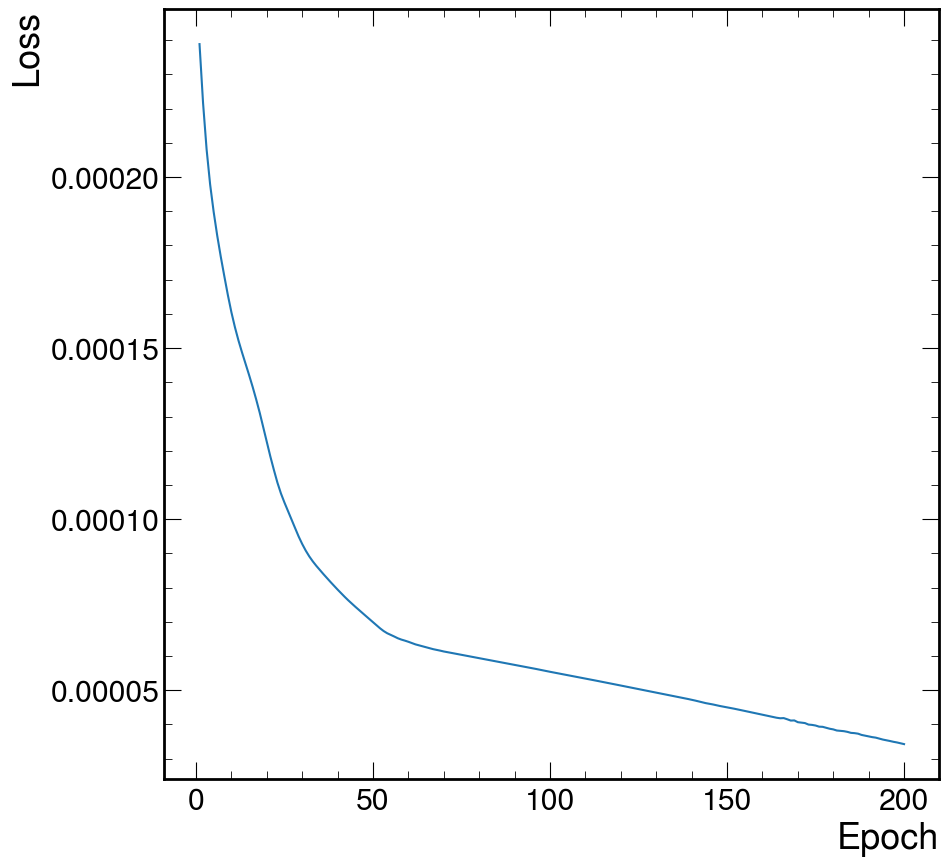

In [37]:
"""
Plot of Loss vs Epoch
"""

figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

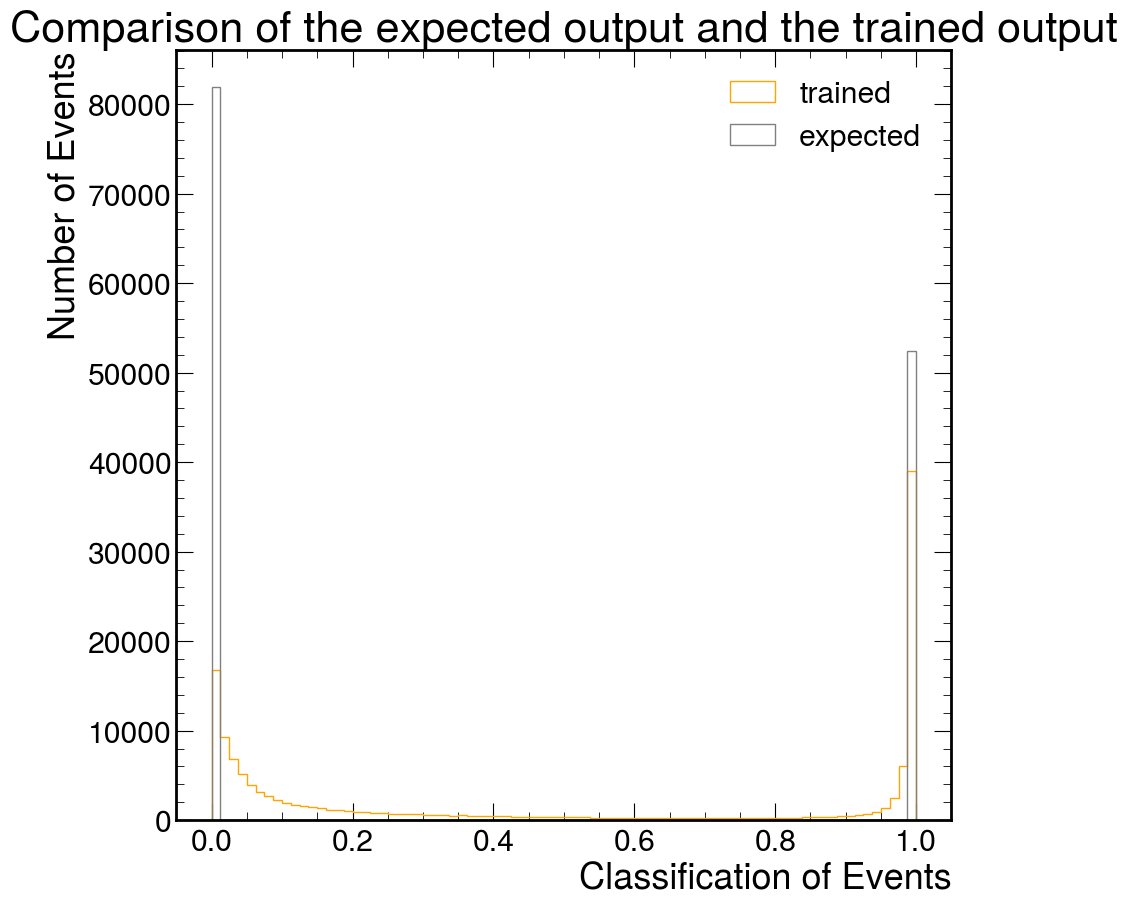

In [38]:
#epoch_= 'Epoch 99'
epoch_=f'Epoch {epochs-1}'
plt.figure()
plt.hist(df_Prediction[epoch_],bins=80,label='trained',histtype="step",color='orange')
plt.hist(train_labels,bins=80,histtype='step',color='grey',label='expected')
plt.legend()
plt.xlabel('Classification of Events')
plt.ylabel('Number of Events')
plt.title('Comparison of the expected output and the trained output')
#plt.savefig(f"BenNeuralNetworkPlots/TrainingHist-{signalname}Epochs={epochs}")
plt.show()

In [39]:
#epoch_= 'Epoch 99'
epoch_=f'Epoch {epochs-1}'
train_labels_=pd.DataFrame({'Classification': train_labels}).reset_index(drop=True)
df_Prediction = pd.concat([df_Prediction, train_labels_], axis=1)


df_Prediction.sort_values(by=[epoch_,'Classification'], ascending=True)
import scipy as scipy

#%%
direction='above' #use this to determine the side of the threshold that calculates TPR and FPR

threshold_direction = f'Signal is {direction} Background'


minimum_edge=0
maximum_edge=1
steps=1000
stepsize=(maximum_edge-minimum_edge)/steps

threshold=minimum_edge
TPR_arr = []
FPR_arr = []
for i in range(0,steps): 
    if threshold_direction == 'Signal is above Background':
        threshold += stepsize
       
        TP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==1)][epoch_])#
        FP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==0)][epoch_])#
        FN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==1)][epoch_])#
        TN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==0)][epoch_])#
        print('run',i)
                
        if (TP+FN) == 0:
            TPR = 0
            FPR = 0
        else:
            TPR = TP/(TP +FN)
            FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        
    elif threshold_direction == 'Signal is below Background':
        threshold += stepsize
       
     #   TP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==1)][epoch_])#
      #  FP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==0)][epoch_])#
       # FN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==1)][epoch_])#
        #TN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==0)][epoch_])#
        
        print('run',i)
        
        TPR = TP/(TP +FN)
        FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        


sorted_values = sorted(zip(FPR_arr, TPR_arr))
FPR_arr, TPR_arr = zip(*sorted_values)


run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

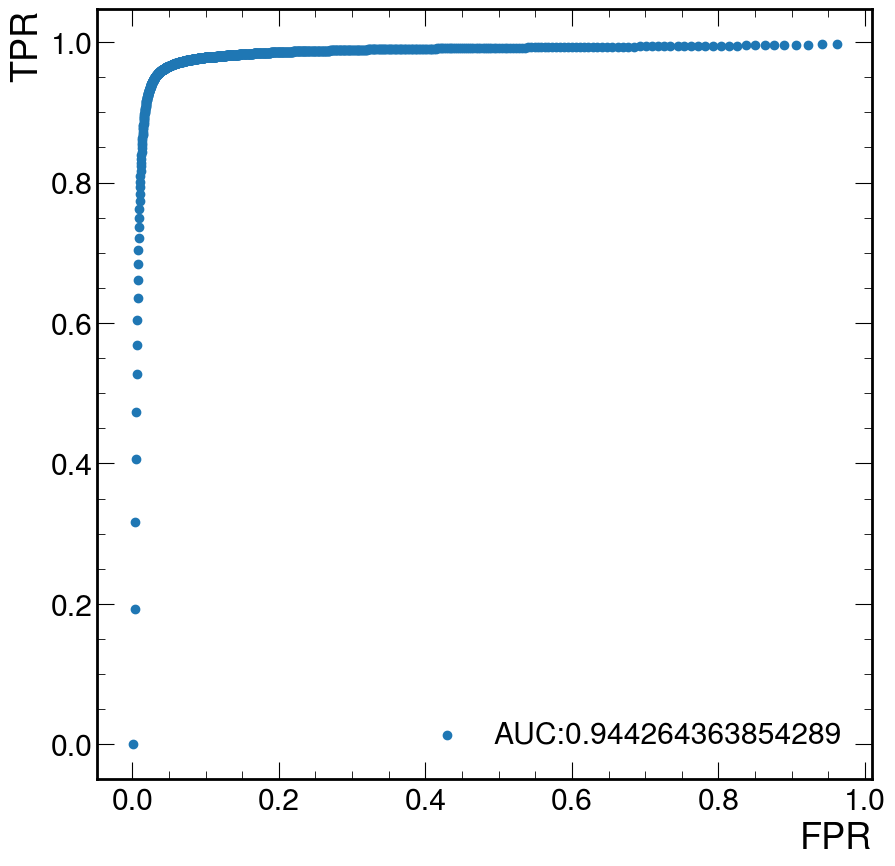

0.944264363854289


In [40]:
AUCscore=scipy.integrate.trapezoid(TPR_arr,FPR_arr,  dx=stepsize,axis=-1)
fig=plt.figure()    
plt.scatter(FPR_arr,TPR_arr,label=f'AUC:{AUCscore}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()
print(AUCscore)

In [26]:
df_Prediction = df_Prediction.drop(columns='Classification')

BenNeuralNetworkPlots/HIST_LOSS_ROC_GluGluToRadionToHHTo2G2Tau_M-1000Epochs=200


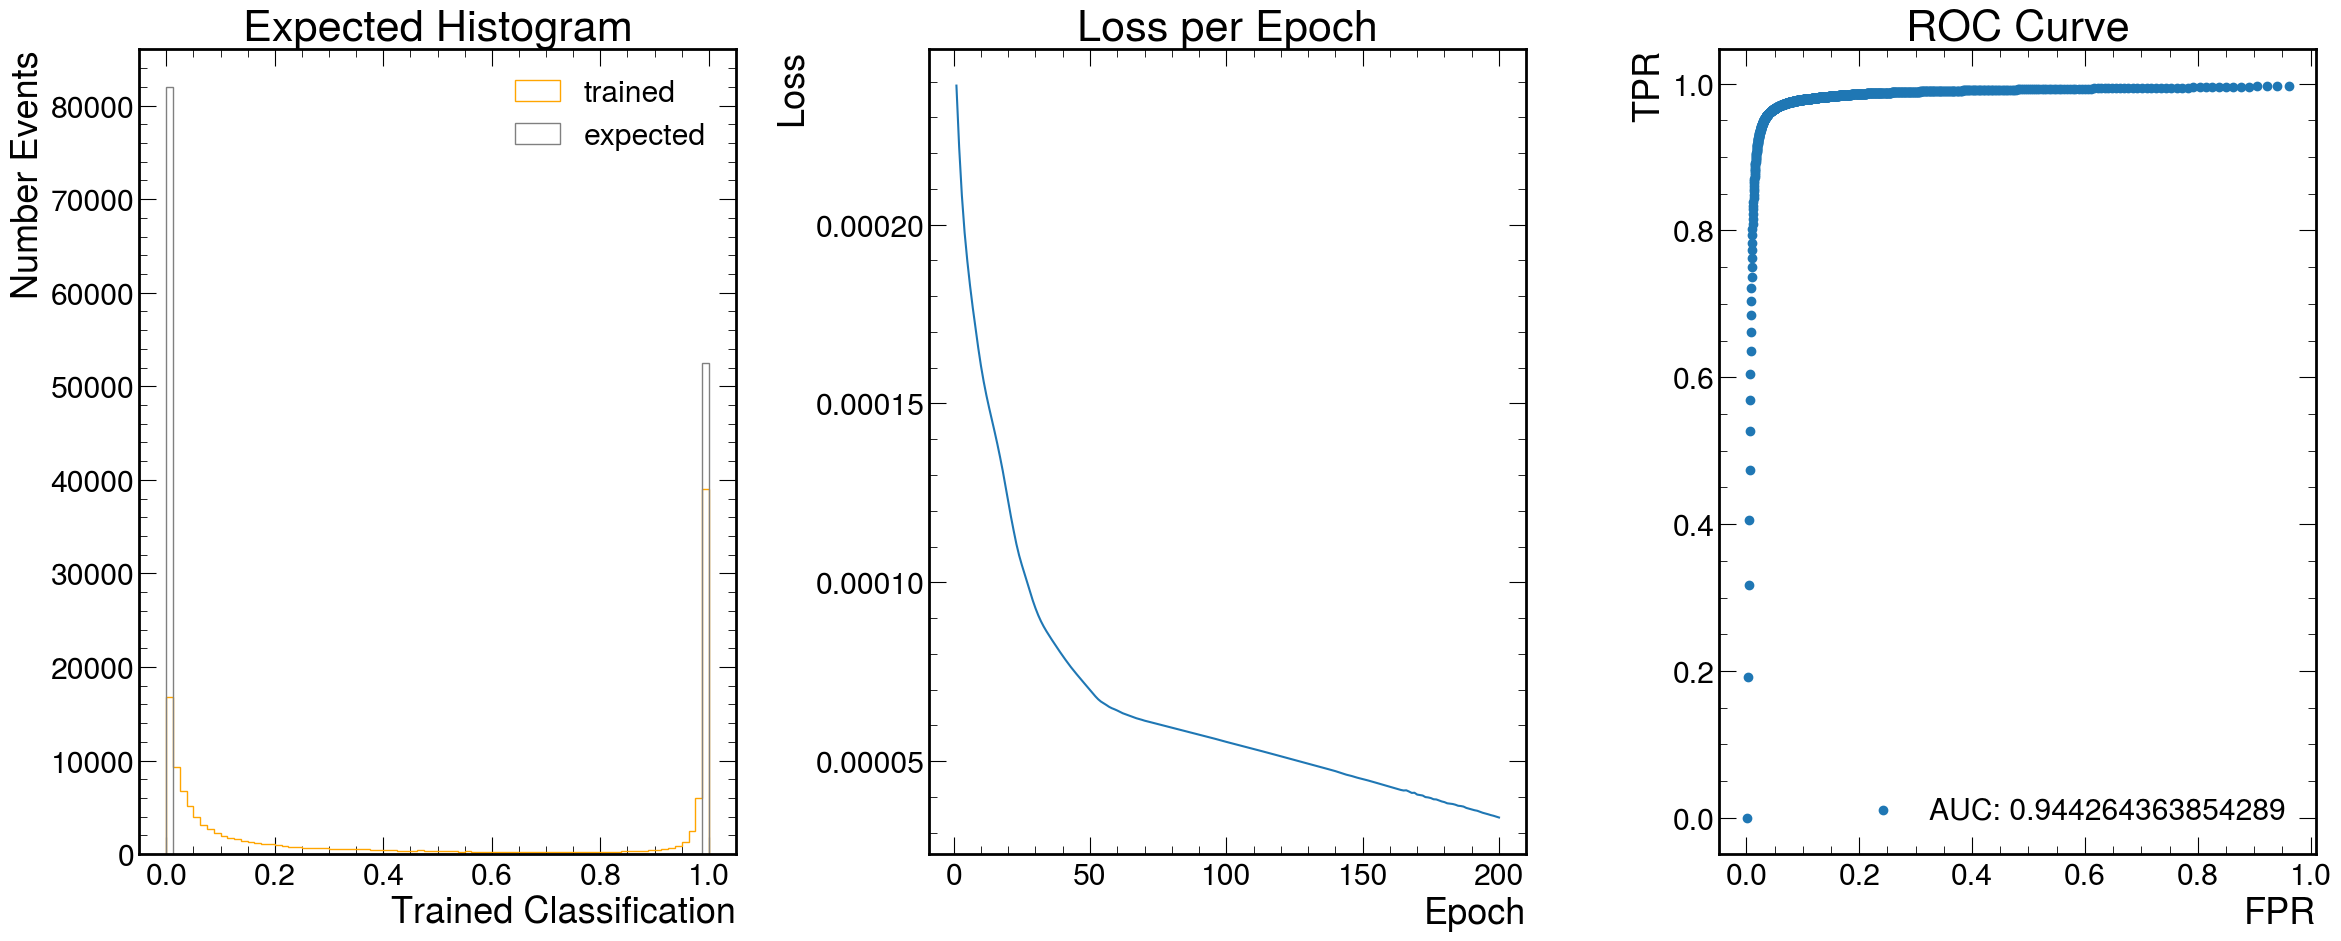

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10))

# Plot 1: Line plot (plt.plot)
axs[1].plot(epochlist, lossdata)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss per Epoch')

# Plot 2: Histograms (two separate subplots)
axs[0].hist(df_Prediction[epoch_], bins=80, label='trained', histtype="step", color='orange')
axs[0].legend()
axs[0].set_title('Trained Histogram')

axs[0].set_xlabel('Trained Classification')
axs[0].set_ylabel('Number Events')

axs[0].hist(train_labels, bins=80, histtype='step', color='grey', label='expected')
axs[0].legend()
axs[0].set_title('Expected Histogram')

# Plot 3: Scatter plot with AUC score
axs[2].scatter(FPR_arr, TPR_arr, label=f'AUC: {AUCscore}')
axs[2].set_xlabel('FPR')
axs[2].set_ylabel('TPR')
axs[2].legend()
axs[2].set_title('ROC Curve')

# Adjust layout and display
plt.tight_layout()
plt.savefig(f"BenNeuralNetworkPlots/HIST_LOSS_ROC_{signalname}Epochs={epochs}")
print(f"BenNeuralNetworkPlots/HIST_LOSS_ROC_{signalname}Epochs={epochs}")

plt.show()


In [28]:
epochs

200

In [256]:
epoch_

'Epoch 199'

In [257]:
print(df_Prediction[epoch_].shape,train_labels.shape)

(120084,) (120084,)
